In [11]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math as m
from time import time
from scipy import stats

In [12]:
import sys
print (sys.version)
if sys.version_info >= (3,4):
    print( "with enums" )
    from enum import Enum
    class CallPut(Enum):
        call = 1
        put = 2
else:
    print( "no enums" )
    class CallPut(object):
        __values__ = ['call', 'put']
        
        def __init__(self, t, s):
            self.value = t
            self.str_value = s

        
        def __eq__(self,y):
            if type(y) is not self.__class__:
                return False
            return self.value == y.value

        def __str__(self):
            return self.str_value
        
        @classmethod 
        def __enum_init__(cls):
            for i in range(len(cls.__values__)):
                setattr(cls, cls.__values__[i], CallPut(i+1, cls.__values__[i]))


    CallPut.__enum_init__()
            
t = CallPut.call
print( "Call: %s; Booleans: %r, %r " %(t, CallPut.call == t, CallPut.put == t) )
print( "Wrong type: %r" % (t == 1) )

2.7.10 (default, Dec 28 2015, 04:30:58) 
[GCC 5.2.1 20151010]
no enums
Call: call; Booleans: True, False 
Wrong type: False


In [4]:
def N(x):
    return stats.norm.cdf(x, 0.0, 1.0)

def NPrime(x):
    return stats.norm.pdf(x, 0.0, 1.0)

def bsm_d1(S, K, T, r, q, sigma):
    S = float(S)
    return (m.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_d2(S, K, T, r, q, sigma):
    S = float(S)
    return (m.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_pv(callPutType, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    d2 = bsm_d2(S, K, T, r, q, sigma)
    if CallPut.call == callPutType:
        return S * N(d1) * m.exp(-q * T) - K * m.exp(-r * T) * N(d2)
    else:
        return K * N(-d2) * m.exp(-r * T)  - S * m.exp(-q * T) * N(-d1)

def bsm_delta(callPutType, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    if CallPut.call == callPutType:
        return N(d1) * m.exp(-q * T)
    else:
        return -N(-d1) * m.exp(-q * T)

S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0;
sigma = 0.2
ref_pv = bsm_pv(CallPut.call, S=S0, K=K, T=T, r=r, q=q, sigma=sigma)
ref_delta = bsm_delta(CallPut.call, S=S0, K=K, T=T, r=r, q=q, sigma=sigma)
print( "ref_pv: %.6f, ref_delta: %.6f " % (ref_pv, ref_delta) )

ref_pv: 5.988244, ref_delta: 0.518694 


In [26]:
S = 100.;  T = 9./12; r = 0.05; q = 0.0;
delta = 0.5
sigma = 0.2
N_d1 = delta / m.exp(-q*T)

In [24]:
from scipy import optimize
import scipy

In [27]:
y = lambda K: stats.norm.cdf((-(m.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))),0.0,1.0) * m.exp(-q * T)-0.5

KO = scipy.optimize.brentq(y, 1e-10, 1000.)
print( "Brent's method: %.8f" % KO )

Brent's method: 105.39025621


In [18]:
optimize.brentq(bsm_delta, -0.5, 0.5,  args =(CallPut.call, S = S1,  T = T1, r = r1, q = q1, sigma = sigma1) )

SyntaxError: invalid syntax (<ipython-input-18-0c7b52d3177c>, line 1)

$\frac{dS}{S} = r dt + \sigma dW_t$


$S(t) = S(t-\Delta t) \exp(r t - \frac{1}{2} \sigma^2 t + \sigma W_t )$

In [4]:
def mc_call_pv0(S0, K, T, r, sigma, M, I):
    # Simulating I paths with M time steps
    S = np.zeros((M + 1, I))
    S[0] = S0
    dt = float(T) / M
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)

    # Calculating the Monte Carlo estimator
    C = m.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I
    return C, S

def mc_call_pv(S0, K, T, r, sigma, M, I):
    # Simulating I paths with M time steps
    S = np.zeros((M + 1, I))
    S[0] = S0
    dt = float(T) / M
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        mean = np.mean(z)
        std = np.std(z)
        z = (z - mean)/std
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)

    # Expected payoff
    E = np.sum(np.maximum(S[-1] - K, 0)) / I
    # PV
    C = m.exp(-r * T) * E
    return C, S


# Parameters
M = 360; I = 50000

np.random.seed(12345)
t0 = time()
C, SPaths = mc_call_pv0(S0, K, T, r, sigma, M, I)
calcTime = time() - t0

print( "PV: %.5f, abs diff: %.5f, rel diff:  %.5f" % (C, ref_pv - C, (ref_pv - C)/C) )
print( "Calculation time   %.5f" % calcTime )

np.random.seed(12345)
t0 = time()
C, SPaths = mc_call_pv(S0, K, T, r, sigma, M, I)
calcTime = time() - t0

print( "PV: %.5f, abs diff: %.5f, rel diff:  %.5f" % (C, ref_pv - C, (ref_pv - C)/C) )
print( "Calculation time   %.5f" % calcTime )

PV: 5.95967, abs diff: 0.02858, rel diff:  0.00480
Calculation time   1.35006
PV: 5.98041, abs diff: 0.00784, rel diff:  0.00131
Calculation time   1.51846


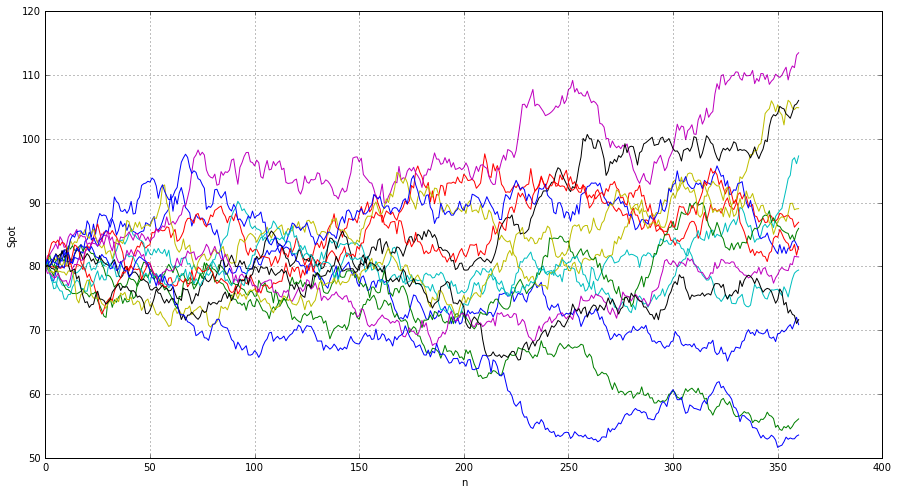

In [5]:
plt.figure(figsize=(15,8))
plt.plot(SPaths[:, :15])
plt.grid(True)
plt.xlabel('n')
plt.ylabel('Spot')

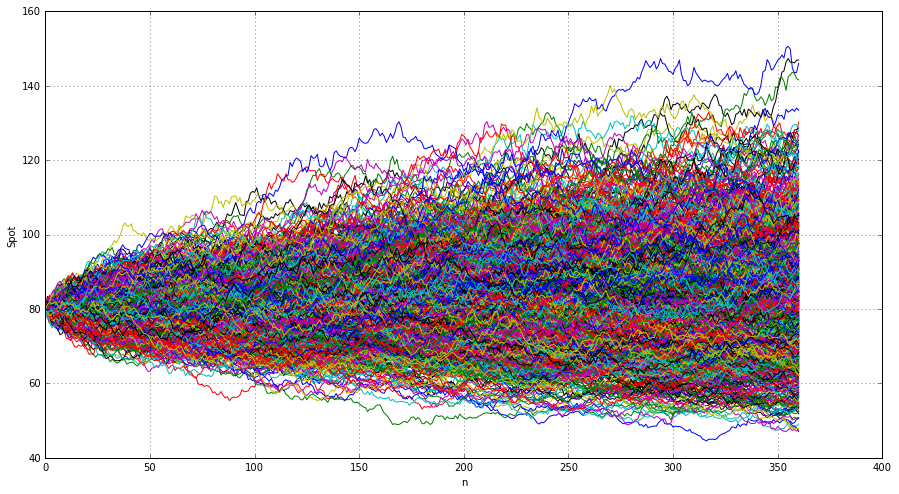

In [6]:
plt.figure(figsize=(15,8))
plt.plot(SPaths[:, :1000])
plt.grid(True)
plt.xlabel('n')
plt.ylabel('Spot')

------  
.  
.  

$\frac{ \partial C  }{ \partial S} \approx \frac{ \Delta C }{ \Delta S} = \frac{ C_{i+1} - C_i }{ \Delta S }$

In [7]:
dS = S0 / 1000.


np.random.seed(12345)
t0 = time()
C0, _ = mc_call_pv(S0, K, T, r, sigma, M, I)
C1, _ = mc_call_pv(S0+dS, K, T, r, sigma, M, I)
delta = (C1 - C0) / dS
calcTime = time() - t0

print( "Delta: %.5f, abs diff: %.5f, rel diff:  %.5f" % (delta, ref_delta - delta, (ref_delta - delta)/delta) )
print( "Calculation time   %.5f" % calcTime )

Delta: 0.53650, abs diff: -0.01781, rel diff:  -0.03319
Calculation time   3.48334


$\frac{ \partial C  }{ \partial S} \approx \frac{ C_{i+1} - C_{i-1} }{ 2 \Delta S }$

In [8]:
np.random.seed(12345)
t0 = time()
C_1, _ = mc_call_pv(S0-dS, K, T, r, sigma, M, I)
C1, _ = mc_call_pv(S0+dS, K, T, r, sigma, M, I)
delta = (C1 - C_1) / (2. * dS)
calcTime = time() - t0

print( "Delta: %.5f, abs diff: %.5f, rel diff:  %.5f" % (delta, ref_delta - delta, (ref_delta - delta)/delta) )
print( "Calculation time   %.5f" % calcTime )

Delta: 0.52795, abs diff: -0.00926, rel diff:  -0.01754
Calculation time   3.76581


-----